<a href="https://colab.research.google.com/github/JohnNuwan/Python_Trading_Repo/blob/master/Sup_Res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
data_to_load = files.upload()

Saving EURUSD.csv to EURUSD.csv


---
# Le trading algorithmique
Le trading algorithmique est un domaine fascinant du trading et des statistiques et l'une des techniques de trading les plus utiles que les traders quantitatifs aimeraient souvent automatiser est l'action des prix, qui est l'analyse des mouvements de prix sans utiliser d'indicateurs dérivés tels que les oscillateurs ou la moyenne mobile.

Dans cet article, je couvrirai un algorithme pour détecter automatiquement deux outils importants de l'action des prix, qui sont les supports et les résistances.

# Que sont les supports et les résistances?

Les supports et résistances sont souvent appelés «niveaux clés». Ce sont des niveaux de prix auxquels le cours de l'action a inversé sa tendance. Si le prix augmente, puis inverse sa tendance à la baisse, le point le plus élevé atteint est appelé résistance. Si le prix a baissé puis commence à augmenter, la valeur de prix la plus basse est appelée support.

Ces niveaux de prix identifient des zones d'offre et de demande, dans lesquelles les commerçants ont augmenté leur volume d'opérations et ont montré un certain intérêt. C'est pourquoi, dès que le prix se rapproche d'un niveau clé, les traders doivent garder les yeux ouverts et voir ce qui se passe.

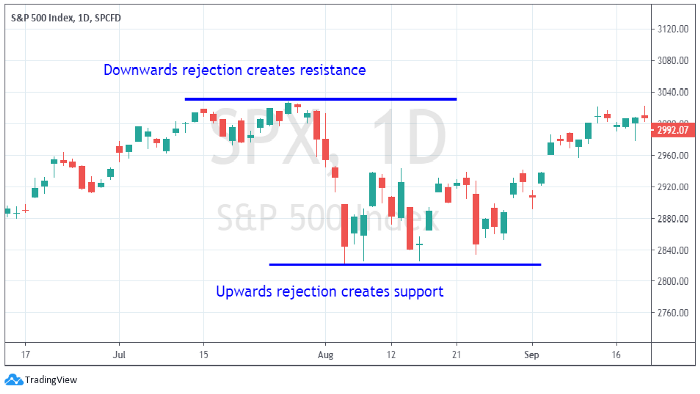

Les niveaux clés sont très importants car de nombreux événements intéressants peuvent se produire à proximité de ces niveaux d'inversion. Par exemple, le marché peut rebondir à nouveau, ce qui permet aux stratégies de retour à la moyenne de gagner ou il peut briser le niveau clé, améliorant ainsi les choses pour les traders en cassure.

Il existe une règle empirique qui dit que plus un niveau clé a été testé (c'est-à-dire que le marché a rebondi plusieurs fois près de lui), plus le niveau est important.

Une autre règle de base est que, une fois qu'un niveau de résistance est cassé, il devient automatiquement un niveau de support. Vice-versa, un niveau de support cassé devient un niveau de résistance. Image pour publication

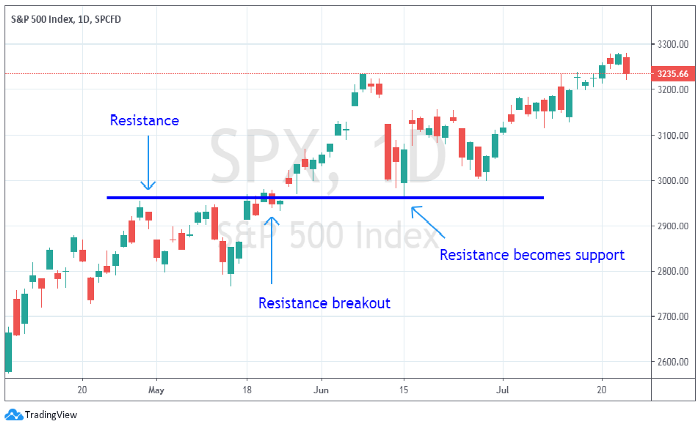

## Niveaux ou zones?

Dans cet article, je ferai référence aux niveaux clés en tant que niveaux de prix, mais certains commerçants disent que les niveaux clés sont des zones, pas des niveaux. Cela se produit parce que la volatilité rend tout plus bruyant, de sorte que les zones d'offre et de demande ne sont jamais aussi claires. C'est pourquoi, dans le trading réel, vous devez toujours envisager une sorte d'enveloppe autour d'un niveau clé, à peu près aussi large que la volatilité (par exemple, la fourchette vraie moyenne, l'écart type). Par souci de simplicité, dans cet article, je considérerai les niveaux clés comme des niveaux de prix fixes et non comme des zones plus larges.

## Comment identifier les niveaux clés

Les niveaux clés sont les points de rejet, nous devons donc vérifier si le marché a atteint un certain niveau et a ensuite refusé d'aller dans la direction opposée.

Une bonne idée est d'utiliser le tableau des chandeliers et de vérifier les prix élevés et bas de chaque bougie. Si une bougie basse est plus basse que la précédente et la prochaine bougie est basse, c'est un support. Ce modèle particulier d'action des prix est appelé swing. Malheureusement, ce modèle présente souvent des défauts dus à la volatilité et au bruit du marché, c'est pourquoi nous pouvons utiliser un meilleur modèle appelé fractal.

## Fractales

Une fractale est un motif de chandelier composé de 5 bougies. La troisième bougie a le prix le plus bas, les bougies précédentes ont des creux décroissants et les bougies suivantes ont des creux croissants. Par ce modèle, le bas de la troisième bougie est le niveau de soutien. Le même concept s'applique aux niveaux de résistance, où la troisième bougie a le plus haut des cinq.

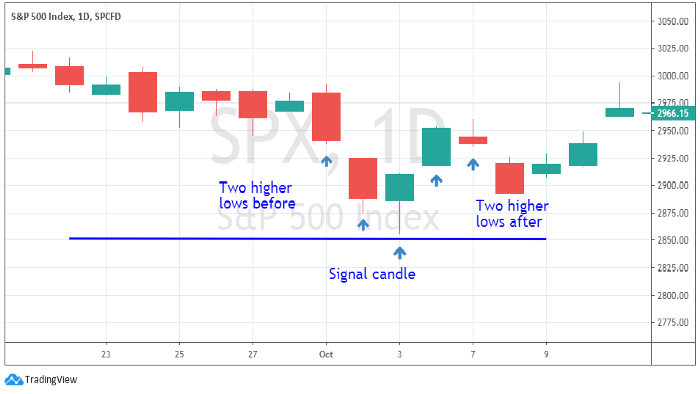

Les fractales sont très utiles car elles suppriment une partie du bruit montré par les swing et identifient les niveaux clés avec une plus grande précision. C’est pourquoi je vais les utiliser dans mon algorithme.

----

# Détection automatique en Python

Importons quelques bibliothèques utiles et initialisons l’environnement de traçage.


In [8]:
# permettant la manipulation et l'analyse des données
import pandas as pd
# destinée à manipuler des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux
import numpy as np

import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

#from mplfinance import candlestick_ohlc

import plotly.graph_objects as go

plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

In [9]:
name = 'EURUSD.csv'
df = pd.read_csv(name)
df['Date']=pd.to_datetime(df['time'], unit='s')
#df['Date'] = pd.to_datetime(df.index)
df = df.loc[:,['Date', 'open', 'high', 'low', 'close']]

In [10]:
# affichage tete tableaux
df.head()

,Date,open,high,low,close
0,2020-01-02 03:00:00,1.12182,1.12244,1.12180,1.12209
1,2020-01-02 04:00:00,1.12208,1.12244,1.12182,1.12221
2,2020-01-02 05:00:00,1.12221,1.12230,1.12123,1.12132
3,2020-01-02 06:00:00,1.12132,1.12142,1.12008,1.12011
4,2020-01-02 07:00:00,1.12011,1.12043,1.12008,1.12043


In [11]:
# Affiche la fin du tableaux
df.tail()

,Date,open,high,low,close
6282,2021-01-06 05:00:00,1.22785,1.22948,1.22753,1.22856
6283,2021-01-06 06:00:00,1.22856,1.23062,1.22834,1.22916
6284,2021-01-06 07:00:00,1.22916,1.23055,1.22915,1.22964
6285,2021-01-06 08:00:00,1.22964,1.23214,1.22962,1.23166
6286,2021-01-06 09:00:00,1.23163,1.23451,1.23122,1.23393


In [13]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],open=df['open'],high=df['high'],low=df['low'],close=df['close'])])
fig.show()

### Créons deux fonctions qui identifient les fractales à 4 bougies

In [14]:
def isSupport(df,i):
  support = df['low'][i] < df['low'][i-1]  and df['low'][i] < df['low'][i+1] and df['low'][i+1] < df['low'][i+2] and df['low'][i-1] < df['low'][i-2]  
  return support

def isResistance(df,i):
  resistance = df['high'][i] > df['high'][i-1]  and df['high'][i] > df['high'][i+1] and df['high'][i+1] > df['high'][i+2] and df['high'][i-1] > df['high'][i-2]
  return resistance

Enfin, créons une liste qui contiendra les niveaux que nous trouvons. Chaque niveau est un tuple dont le premier élément est l'indice de la bougie de signalisation et le deuxième élément est la valeur du prix.

In [15]:
levels = []
for i in range(2,df.shape[0]-2):
  if isSupport(df,i):
    levels.append((i,df['low'][i]))
  elif isResistance(df,i):
    levels.append((i,df['high'][i]))

Nous pouvons maintenant définir une fonction qui trace le prix et les niveaux clés ensemble.

In [20]:
def plot_all():
    fig, ax = plt.subplots()

    fig = go.Figure(data=[go.Candlestick(x=df['Date'],open=df['open'],high=df['high'],low=df['low'],close=df['close'])])

    #plt.plot(df["close"])
    #ax.xaxis.set_major_formatter(df["Date"])
    #fig.autofmt_xdate()
    #fig.tight_layout() 
    for level in levels:
        plt.hlines(level[1],xmin=df['Date'][level[0]], xmax=max(df['Date']),colors='blue')
        #plt.hlines(level[1],xmin=df['Date'][level[0]],\xmax=max(df['Date']),colors='blue')
    fig.show()

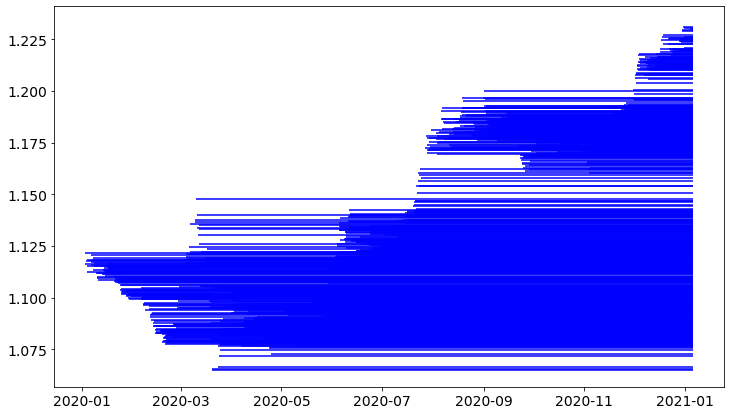

In [21]:
plot_all()

In [22]:
s =  np.mean(df['high'] - df['low'])
print(s)

0.0015760792110704658


In [23]:
def isFarFromLevel(l):
    return np.sum([abs(l-x) < s  for x in levels]) == 0

In [24]:
levels = []
for i in range(2,df.shape[0]-2):
    if isSupport(df,i):
        l = df['low'][i]

        if isFarFromLevel(l):
            levels.append((i,l))

    elif isResistance(df,i):
        l = df['high'][i]

        if isFarFromLevel(l):
            levels.append((i,l))

In [25]:
levels

[(8, 1.1213799999999998),
 (16, 1.1163399999999999),
 (34, 1.11248),
 (39, 1.1179700000000001),
 (134, 1.1093),
 (197, 1.1144399999999999),
 (302, 1.10766),
 (375, 1.10362),
 (380, 1.10588),
 (399, 1.10197),
 (446, 1.0997700000000001),
 (614, 1.0964200000000002),
 (640, 1.09417),
 (671, 1.0907799999999999),
 (684, 1.08917),
 (703, 1.09255),
 (714, 1.0865200000000002),
 (742, 1.08417),
 (792, 1.08229),
 (805, 1.07855),
 (816, 1.08035),
 (985, 1.09819),
 (1100, 1.12445),
 (1117, 1.13545),
 (1140, 1.13754),
 (1144, 1.14786),
 (1159, 1.1401),
 (1161, 1.13357),
 (1184, 1.1301),
 (1335, 1.06548),
 (1371, 1.07682),
 (1386, 1.07165),
 (1408, 1.0745799999999999),
 (2603, 1.1195700000000002),
 (2678, 1.12785),
 (2698, 1.13183),
 (2751, 1.14221),
 (2881, 1.12609),
 (3404, 1.14455),
 (3447, 1.15396),
 (3461, 1.15066),
 (3466, 1.1601),
 (3471, 1.15626),
 (3508, 1.16211),
 (3511, 1.1581),
 (3528, 1.17248),
 (3540, 1.17811),
 (3557, 1.1698600000000001),
 (3592, 1.17536),
 (3610, 1.18093),
 (3708, 1.1

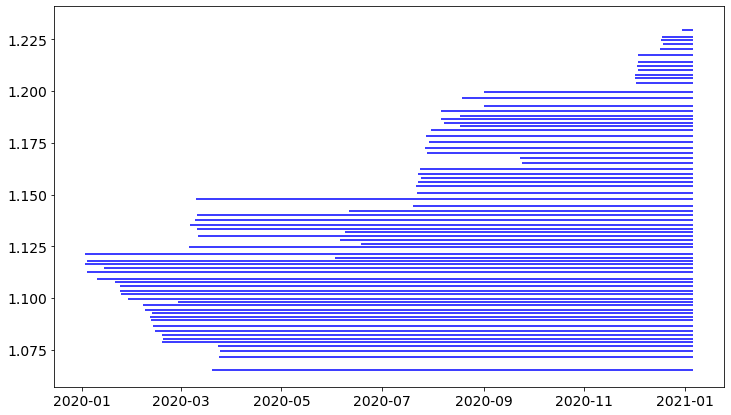

In [26]:
plot_all()

Maintenant, les niveaux sont plus clairs, ils ne se superposent pas et nous pouvons facilement voir que parfois les prix sautent à chaque niveau plus d'une fois.

## Conclusions

L'automatisation des niveaux de prix peut être très utile pour un trader quantitatif et peut supprimer une partie du bruit du marché en rendant le graphique plus clair. Les niveaux clés peuvent être utilisés pour des stratégies de réversion de la moyenne (c'est-à-dire acheter lorsque le prix rebondit à partir d'un niveau de support) ou pour des stratégies de cassure (c'est-à-dire acheter lorsque le prix franchit un niveau de résistance).
